In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from bloqade.analog import start
from scipy.optimize import minimize

In [9]:
def generate_mis_graph_from_2sat(clauses):

    G = nx.Graph()

    for clause_idx, clause in enumerate(clauses):
        for lit in clause:
            node = len(G)
            var = abs(lit)
            val = 1 if lit > 0 else 0
            G.add_node(node, clause=clause_idx, var=var, val=val)

    nodes = list(G.nodes(data=True))
    for i, (u, udata) in enumerate(nodes):
        for v, vdata in nodes[i+1:]:
            if udata['clause'] == vdata['clause']:
                G.add_edge(u, v, type='clause')
            elif udata['var'] == vdata['var'] and udata['val'] != vdata['val']:
                G.add_edge(u, v, type='var')

    return G

def visualize_graph(G):

    pos = nx.spring_layout(G, seed=42)
    
    clause_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'clause']
    var_edges    = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'var']
    
    nx.draw_networkx_nodes(G, pos, node_size=1000)
    
    nx.draw_networkx_edges(G, pos, edgelist=clause_edges, style='solid', edge_color = 'red')
    nx.draw_networkx_edges(G, pos, edgelist=var_edges,   style='dashed')
    
    labels = {
        n: f"c{data['clause']}:\nx{data['var']}={data['val']}"
        for n, data in G.nodes(data=True)
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color = 'white')
    
    plt.axis('off')
    plt.show()

def layout_objective(x, G, r_b, d_min,
                     w_clause=10.0, w_var=1.0, w_non=1.0, w_min=50.0,
                     dim=2):

    X = x.reshape(-1, dim)
    loss = 0.0
    N = len(G)

    # clause and variable edges 
    for u, v, data in G.edges(data=True):
        d = np.linalg.norm(X[u] - X[v])
        if data['type'] == 'clause':
            # pull clause paris together strongly
            loss += w_clause * (d - r_b)**2
        else: 
            # pull connected verticies towards r_b less strongly
            loss += w_var * (d - r_b)**2

    # push non-edges outside the blockade radius
    for i in range(N):
        for j in range(i+1, N):
            if not G.has_edge(i, j):
                d = np.linalg.norm(X[i] - X[j])
                loss += w_non * np.exp(-(d / r_b)**2)

    # Ensure minimum spacing
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(X[i] - X[j])
            if d < d_min:
                loss += w_min * (d_min - d)**2

    return loss

def solution_cost(bitstr: str, G: nx.Graph,
         penalty_clause_conflict: float = 5.0,
         penalty_var_conflict: float = 5.0) -> float:

    # identify selected nodes (bit == '0')
    selected = {i for i, b in enumerate(bitstr) if b == '0'}

    # Group nodes by clause
    clause_nodes = {}
    for node, data in G.nodes(data=True):
        clause = data['clause']
        clause_nodes.setdefault(clause, []).append(node)

    # clause penalties
    unsatisfied = 0
    clause_conflicts = 0
    for nodes in clause_nodes.values():
        sel = [n for n in nodes if n in selected]
        if len(sel) == 0:
            unsatisfied += 1
        elif len(sel) > 1:
            clause_conflicts += 1

    # variable consistency penalties
    var_assigns = {}
    for n in selected:
        var = G.nodes[n]['var']
        val = G.nodes[n]['val']
        var_assigns.setdefault(var, set()).add(val)
    var_conflicts = sum(1 for vals in var_assigns.values() if len(vals) > 1)

    # total cost
    cost = (unsatisfied
            + penalty_clause_conflict * clause_conflicts
            + penalty_var_conflict * var_conflicts)
    return cost

def expectation(counts: dict, G: nx.Graph,
                penalty_clause_conflict: float = 10,
                penalty_var_conflict: float = 10) -> float:

    total_shots = sum(counts.values())
    if total_shots == 0:
        return 0.0

    total_cost = 0.0
    for bitstr, cnt in counts.items():
        cost = solution_cost(
            bitstr, G,
            penalty_clause_conflict=penalty_clause_conflict,
            penalty_var_conflict=penalty_var_conflict
        )
        total_cost += cost * cnt

    return total_cost / total_shots

def pretty_print_clauses(clauses, bitstr):

    assignment = {}
    for i, (lit1, lit2) in enumerate(clauses):
        b1 = bitstr[2*i]
        b2 = bitstr[2*i + 1]
        if b1 == '0':
            var = abs(lit1)
            assignment[var] = True if lit1 > 0 else False
        if b2 == '0':
            var = abs(lit2)
            assignment[var] = True if lit2 > 0 else False

    vars_all = sorted({abs(l) for clause in clauses for l in clause})
    print("Variable assignment:")
    for v in vars_all:
        val = assignment.get(v, None)
        val_str = {True: "True", False: "False", None: "unspecified"}[val]
        print(f"  x{v} = {val_str}")
    print()

    def lit_str(lit):
        return f"x{lit}" if lit > 0 else f"¬x{abs(lit)}"
    def eval_lit(lit):
        v = abs(lit)
        if v not in assignment: 
            return False
        val = assignment[v]
        return val if lit > 0 else (not val)

    for idx, (lit1, lit2) in enumerate(clauses, start=1):
        clause_repr = f"({lit_str(lit1)} ∨ {lit_str(lit2)})"
        sat = eval_lit(lit1) or eval_lit(lit2)
        status = "satisfied" if sat else "unsatisfied"
        print(f"Clause {idx}: {clause_repr} -> {status}")

## 1. What is Max-2-SAT?

Max-2-SAT is an optimisation variant of the classic satisfiability problem. We hae a set of Boolean clauses written in *conjunctive normal form* meaning that every clause is an OR ($\lor$) statement with un-negated ($x$) or negated ($\lnot x$) Boolean variables, for example:
$$
(x_1 \lor  x_2)
$$
$$
(\lnot x_1 \lor x_2)
$$
$$
(x_1 \lor \lnot x_2)
$$
$$
(\lnot x_1 \lor \lnot x_2)
$$

The goal is to find an assignment of True and False to the Boolean variables $x_i$ that satisfies the largest possible number of clauses. Formally, given $m$ clauses $C_1,\dots,C_m$ over variables $x_1,\dots,x_n$, we want an assignment $\mathbf{x}\in\{0,1\}^n$ that maximises 
$$
\sum_{k=1}^{m}\mathbf{1}\!\bigl[C_k(\mathbf{x})=1\bigr].
$$  

## Why is it interesting?

- Benchmark for classical approximation algorithms.
- Canonical NP‑hard problem that shows up as a gadget in many reductions.
- Natural starting point for quantum optimisation because every clause maps to a local two‑body term in a Hamiltonian.


## 2 · Building the conflict graph

To recast a Max-2-SAT instance as a Maximum Independent Set (MIS) problem, we first construct a *conflict graph*.  For every clause we introduce two vertices.  An edge joins the pair from the same clause so that at most one of them can be chosen—mirroring the property that only open element need be true to statisfy an OR state.  

Next, every vertex representing variable $x_i$ is connected to every vertex representing $\lnot x_i$.

The resulting graph has $2m$ vertices and a polynomial number of edges, with two edge types: “clause” edges enforce one-per-clause selection, and “variable” edges that enforce logical consistency.

A *maximum* independent set in this graph corresponds *one‑to‑one* to an assignment that satisfies the maximum number of clauses.

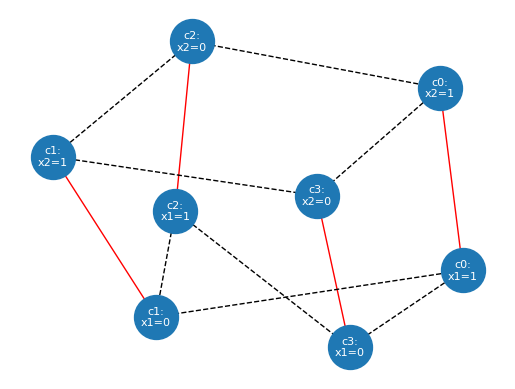

In [ ]:
clauses = [
    (1,  2),
    (-1, 2),
    (1, -2),
    (-1,-2)
]

G = generate_mis_graph_from_2sat(clauses)

visualize_graph(G) # red edges indicate a clauses, dashed edges a conflict
j

### 3 · From abstract graph to physical layout

To embed the logical conflict graph on an analogue neutral-atom processor such as QuEra’s Aquila, we leverage the Rydberg *blockade*: once an atom is driven to its Rydberg state, nearby atoms inside a radius $r_b$ are probhibited from simultaneous excitation.  

Our goal is to derive an atom placement such that atoms representing non-adjacent vertices never fall within the blockade radius, while atoms representing adjacent vertices stay close enough to maintain the blockade effect.  

We begin with a spring layout—NetworkX’s force-directed algorithm—which treats edges like elastic springs and produces a reasonably spaced initial geometry. Next, these coordinates are flattend into a length-$2|V|$ vector gives and further optimised.

The optimised coodinates are passed to the `bloqade.start.add_position` method to define the atom geometry on which we will build our optimisation program.

In [5]:
# get initial positions from a networkx spring layout
initial_pos = nx.spring_layout(G, seed=42, dim=2, k = 2)
node_list = list(G.nodes)
index_map = {node: i for i, node in enumerate(node_list)}
positions_array = np.array([initial_pos[node] for node in node_list])
x0 = positions_array.flatten()

r_b = 6.5 # blockade radius
r_min = 6.0 # minimum distance

res = minimize(layout_objective, x0, args=(G, r_b, r_min), method='BFGS')
final_positions = res.x.reshape(-1, 2)
scaled_pos_dict = {node: final_positions[i] for i, node in enumerate(node_list)}

positions = np.array(list(scaled_pos_dict.values()))
geometry = start.add_position(positions)  
print(geometry)

                                   Atom Positions                               
    ┌──────────────────────────────────────────────────────────────────────────┐
 5.1┤                                                       •                  │
    │                            •                                             │
    │                                                                          │
 3.2┤•                                                                         │
    │                                                                          │
    │                                                                          │
 1.3┤                                                                          │
    │                                                                         •│
    │                                                                          │
-0.6┤                                            •                             │
    │                 •     

### 4 · Designing a pulse schedule

There are different pulse-protocols that can be applied to this problem. Here we define an Ansatz that draws from the general structure of the alternating unitaries of Grover's search.

We first apply the Rabi drive to prepare a superposition over the space of possible solutions. This is followed by a period of global detuning, which produces a phase-rotation proportional to the number of excitations in each state. Finally we apply the Rabi drive again producing solution-dependent interference effects to produce convergence to optimal or near-optimal solutions.

Each pulse has a trapezoid shape, defined by a ramp up from zero to a target amplitude, a period of constant amplitude, and a ramp back down to zero.

Our pulse template follows the pattern **Rabi → Detune → Rabi**.

Parameter map:
| Symbol | Code variable | Physical meaning |
|--------|---------------|------------------|
| \(t_2\)   | `t2`           | area of the **first** global Rabi pulse |
| \(t_6\)   | `t6`           | area of the **second** global Rabi pulse |
| \(t_{10}\) | `t10`          | duration of the detuning plateau between the two |

In [7]:
rabi_durations = [f"t{i}" for i in range(1, 8)]
rabi_amplitudes = [f"omega{i}" for  i in range(1, 9)]
detuning_durations = [f"t{i}" for i in range(8, 13)]
detuning_amplitudes = [f"delta{i}" for i in range(1, 7)]

prog_args = rabi_durations + rabi_amplitudes + detuning_durations + detuning_amplitudes

prog = geometry
prog = prog.rydberg.rabi.amplitude.uniform.piecewise_linear(durations = rabi_durations, values = rabi_amplitudes)
prog = prog.rydberg.detuning.uniform.piecewise_linear(durations = detuning_durations, values = detuning_amplitudes)

prog = prog.args(prog_args)

def map_parameters(x):
    t2, t6, t10 = x
    rts = [0.05, t2, 0.05, 0.1 + t10, 0.05, t6, 0.05]
    ras = [0, 15.8,  15.8, 0, 0, 15.8, 15.8, 0]
    dts = [0.1 + t2,  0.05, t10, 0.05, 0.1 + t6]
    das = [0,  0, 2 * np.pi, 2 * np.pi, 0, 0]
    return tuple(rts + ras + dts + das)


The resulting ansatz is defined by three variational parameters, $t_2$, $t_6$ and $t_10$, that dictate the total integrated pulse area of the first rabi pulse, second rabi pulse and seperating detuning pulse respectively.

We optimise these parameters using `COBYLA`, with `100` shots per-computation of the solution expectation value, with the lower bound reflecting the minimum pulse segement length supported by Aquila of 0.05 microseconds.

In [ ]:
def objective(x, clauses,  prog, shots):
    result = prog.bloqade.python().run(shots=shots, args =  map_parameters(x), blockade_radius = r_b)
    cost = expectation(result.report().counts()[0], G)
    return cost

shots = 100
result = minimize(objective, [0.2, 0.2, 0.2], args = (clauses, prog, shots), bounds = ([0.05, 2.5,], [0.05, 2.5], [0.05, 1.0]), method = "COBYLA")
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 6.45
       x: [ 5.004e-02  1.882e+00  1.860e-01]
    nfev: 41
   maxcv: 0.0


In [111]:
job = prog.bloqade.python().run(shots=1000, args =  map_parameters(result['x']))
for solution in list(job.report().counts()[0].keys())[::5]:
    print(f'\nSolution: {solution}')
    pretty_print_clauses(clauses, solution)


Solution: 11011011
Variable assignment:
  x1 = False
  x2 = False

Clause 1: (x1 ∨ x2) -> unsatisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: (x1 ∨ ¬x2) -> satisfied
Clause 4: (¬x1 ∨ ¬x2) -> satisfied

Solution: 11110111
Variable assignment:
  x1 = True
  x2 = unspecified

Clause 1: (x1 ∨ x2) -> satisfied
Clause 2: (¬x1 ∨ x2) -> unsatisfied
Clause 3: (x1 ∨ ¬x2) -> satisfied
Clause 4: (¬x1 ∨ ¬x2) -> unsatisfied

Solution: 11111101
Variable assignment:
  x1 = False
  x2 = unspecified

Clause 1: (x1 ∨ x2) -> unsatisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: (x1 ∨ ¬x2) -> unsatisfied
Clause 4: (¬x1 ∨ ¬x2) -> satisfied

Solution: 11111010
Variable assignment:
  x1 = unspecified
  x2 = False

Clause 1: (x1 ∨ x2) -> unsatisfied
Clause 2: (¬x1 ∨ x2) -> unsatisfied
Clause 3: (x1 ∨ ¬x2) -> satisfied
Clause 4: (¬x1 ∨ ¬x2) -> satisfied

Solution: 01011111
Variable assignment:
  x1 = False
  x2 = unspecified

Clause 1: (x1 ∨ x2) -> unsatisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: 